## Lec 7. 自然语言处理 NLP (Nature Language Processing)

- 传统自然语言处理
    - 分词 jieba
    - 命名实体识别
    - 关系抽取
    - TD-IDF
    - ......
- 深度学习自然语言处理
    - 大语言模型 Large Language Model
 
- 文本 -> 向量
    - Label Encoding 类别编码 (词元 Token)
    - One-Hot Encoding 独热编码
    - Embedding 嵌入
 
### 7.1 词汇表 Vocab & 文本向量化

In [1]:
import torch
import torch.nn as nn

In [2]:
class Vocab:
    """ 用于存储单词词元映射关系的词典 """
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []

    def add(self, word):
        """ 向词典中添加新的单词 """
        if word not in self.idx2word:
            self.word2idx[word] = len(self.idx2word)
            self.idx2word.append(word)

    def get_dummies(self, word):
        if word in self.idx2word:
            one_hot = torch.zeros(len(self.idx2word))
            one_hot[self.word2idx.get(word)] = 1
            return one_hot

    def __len__(self):
        return len(self.idx2word)

vocab = Vocab()
corpus = ["Apple", "Banana", "Orange", "Peach"]

for word in corpus:
    vocab.add(word)

vocab.idx2word, vocab.word2idx

(['Apple', 'Banana', 'Orange', 'Peach'],
 {'Apple': 0, 'Banana': 1, 'Orange': 2, 'Peach': 3})

In [3]:
# 类别编码
vocab.word2idx.get("Orange"), vocab.idx2word[3]

(2, 'Peach')

In [4]:
# 独热编码
vocab.get_dummies("Orange")

tensor([0., 0., 1., 0.])

In [5]:
# 词嵌入 Embedding (词向量 word vector) -> 1024
embedding_layer = nn.Linear(4, 1024)

embedded = vocab.get_dummies("Orange")
embedded = embedding_layer(embedded)
embedded

tensor([ 0.1120, -0.2026, -0.4432,  ..., -0.3879,  0.7417, -0.4678],
       grad_fn=<ViewBackward0>)

### 7.2 文本预处理

- 读取文本文件，构建一个文本预处理函数用于处理其中的每一行
    - 过滤掉所有的标点符号
    - 单词全部转化为小写形式
    - ......
- 将每一行的文本预料，转化为一个字符串列表 `List[Str]`
- 所有文本列表中的单词，添加到我们的Vocab词汇表中

In [6]:
import pandas as pd

df_text = pd.read_csv("E:\文件\Amazon-Product-Reviews - Amazon Product Review.csv")[["review_body", "sentiment"]]
df_text

,review_body,sentiment
0,Great love it,1
1,Lots of ads<br />Slow processing speed<br />Oc...,0
2,Excellent unit. The versatility of this table...,1
3,I bought this on Amazon Prime so I ended up bu...,1
4,All Amazon products continue to meet my expect...,1
...,...,...
30841,[[VIDEOID:moP3B6GS5RL8LY]]I purchased the orig...,1
30842,I'm writing this review with the benefit of be...,1
30843,"I purchased this Kindle for my grandma, becaus...",1
30844,I bought my tablet Fire HD 7 at Best Buy on th...,1


In [7]:
def text_preprocessing(doc: str) -> list:
    """ 文本预处理 """
    stop_words = [",", ".", "!", "?", "=", r"\n", "'", '"', "(", ")", "[", "]", "a", "an", "the", "<br", "/>"]
    items = doc.split(" ")
    return [item.lower() for item in items if item not in stop_words]

In [8]:
text_preprocessing("Lots of ads<br />Slow processing speed<br />")

['lots', 'of', 'ads<br', '/>slow', 'processing', 'speed<br']

In [9]:
df_text["review_words"] = df_text["review_body"].apply(lambda x: text_preprocessing(str(x)))
df_text["review_words_count"] = df_text["review_words"].apply(lambda x: len(x))

df_text

,review_body,sentiment,review_words,review_words_count
0,Great love it,1,"[great, love, it]",3
1,Lots of ads<br />Slow processing speed<br />Oc...,0,"[lots, of, ads<br, />slow, processing, speed<b...",25
2,Excellent unit. The versatility of this table...,1,"[excellent, unit., , the, versatility, of, thi...",110
3,I bought this on Amazon Prime so I ended up bu...,1,"[i, bought, this, on, amazon, prime, so, i, en...",202
4,All Amazon products continue to meet my expect...,1,"[all, amazon, products, continue, to, meet, my...",8
...,...,...,...,...
30841,[[VIDEOID:moP3B6GS5RL8LY]]I purchased the orig...,1,"[[[videoid:mop3b6gs5rl8ly]]i, purchased, origi...",1941
30842,I'm writing this review with the benefit of be...,1,"[i'm, writing, this, review, with, benefit, of...",1852
30843,"I purchased this Kindle for my grandma, becaus...",1,"[i, purchased, this, kindle, for, my, grandma,...",346
30844,I bought my tablet Fire HD 7 at Best Buy on th...,1,"[i, bought, my, tablet, fire, hd, 7, at, best,...",285


In [10]:
df_text.review_words_count.max(), df_text.review_words_count.min()

(2216, 0)

In [11]:
vocab = Vocab()
vocab.add("<PAD>")

for idx, row in df_text.iterrows():
    for word in row.review_words:
        vocab.add(word)

In [12]:
len(vocab)

38177

In [13]:
df_text["reviews_tokens"] = df_text["review_words"].apply(lambda x: [vocab.word2idx.get(token) for token in x])
df_text

,review_body,sentiment,review_words,review_words_count,reviews_tokens
0,Great love it,1,"[great, love, it]",3,"[1, 2, 3]"
1,Lots of ads<br />Slow processing speed<br />Oc...,0,"[lots, of, ads<br, />slow, processing, speed<b...",25,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,..."
2,Excellent unit. The versatility of this table...,1,"[excellent, unit., , the, versatility, of, thi...",110,"[29, 30, 31, 32, 33, 5, 34, 35, 36, 37, 38, 39..."
3,I bought this on Amazon Prime so I ended up bu...,1,"[i, bought, this, on, amazon, prime, so, i, en...",202,"[26, 115, 34, 54, 116, 117, 118, 26, 119, 120,..."
4,All Amazon products continue to meet my expect...,1,"[all, amazon, products, continue, to, meet, my...",8,"[131, 116, 202, 203, 42, 204, 76, 205]"
...,...,...,...,...,...
30841,[[VIDEOID:moP3B6GS5RL8LY]]I purchased the orig...,1,"[[[videoid:mop3b6gs5rl8ly]]i, purchased, origi...",1941,"[37987, 175, 1047, 163, 77, 59, 7659, 24, 429,..."
30842,I'm writing this review with the benefit of be...,1,"[i'm, writing, this, review, with, benefit, of...",1852,"[427, 1660, 34, 664, 49, 5068, 5, 37, 2474, 16..."
30843,"I purchased this Kindle for my grandma, becaus...",1,"[i, purchased, this, kindle, for, my, grandma,...",346,"[26, 175, 34, 163, 22, 76, 4116, 176, 26, 150,..."
30844,I bought my tablet Fire HD 7 at Best Buy on th...,1,"[i, bought, my, tablet, fire, hd, 7, at, best,...",285,"[26, 115, 76, 23, 77, 331, 817, 234, 469, 388,..."


### 7.3 文本情感分析 Sentiment Analysis

In [14]:
# 1. 构建数据集
from torch.utils.data import Dataset, DataLoader

class TextSentimentDataset(Dataset):
    def __init__(self, reviews_tokens, sentiment, seq_len: int=20):
        self.label = sentiment
        self.data = []
        for line in reviews_tokens:
            if len(line[:seq_len])<seq_len:
                self.data.append(line[:seq_len] + [vocab.word2idx.get("<PAD>")] * (seq_len - len(line)))
            else:
                self.data.append(line[:seq_len])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx]), torch.tensor(self.label[idx])

from sklearn.model_selection import train_test_split

# 假设 X 是特征数据，y 是标签数据
X_train, X_test, y_train, y_test = train_test_split(df_text.reviews_tokens.values, df_text.sentiment.values, test_size=0.25, random_state=42)

train_dataset = TextSentimentDataset(X_train, y_train)
test_dataset = TextSentimentDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

len(train_dataset), len(test_dataset)

(23134, 7712)

In [15]:
x, y = test_dataset[:16]
x.shape, y.shape

(torch.Size([16, 20]), torch.Size([16]))

In [16]:
x, y = train_dataset[:16]
x.shape, y.shape

(torch.Size([16, 20]), torch.Size([16]))

In [17]:
# 2. 模型构建
class TextSentimentClassifer(nn.Module):
    """ 文本情感分类器 """
    def __init__(self, vocab_size, seq_len, input_size, hidden_size, num_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, input_size)
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers)
        self.classifier = nn.Sequential(nn.Flatten(), 
                                        nn.Linear(seq_len * hidden_size, hidden_size//4), 
                                        nn.PReLU(), 
                                        nn.Linear(hidden_size//4, 4))

    def forward(self, x):
        """ 前向传播方法 """
        # x: [batch_size, seq_len]
        # print(f"x: {x.shape}")
        
        embedded = self.embedding(x) # embedded: [batch_size, seq_len, input_size]
        # print(f"embedded: {embedded.shape}")
        
        output, _ = self.rnn(embedded)  # output: [batch_size, seq_len, hidden_size]
        # print(f"output: {output.shape}")
        
        return self.classifier(output)  # [batch_size, 2]

In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = TextSentimentClassifer(vocab_size=len(vocab), 
                               seq_len=20, 
                               input_size=32, 
                               hidden_size=64, 
                               num_layers=4)
model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [19]:
model(torch.zeros(16, 20).long().to(device)).shape

torch.Size([16, 4])

In [20]:
# 3. 训练模型
def train_model(model, train_dataloader, loss_func, optimizer):
    """ 模型训练函数 """
    total_loss = 0.
    for x, y in train_dataloader:
        y_hat = model(x.to(device))
        loss = loss_func(y_hat, y.to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Train Loss: {total_loss/len(train_dataloader): .4f}")
    return total_loss/len(train_dataloader)

# 4. 验证模型
def test_model(model, test_dataloader, loss_func):
    """ 训练模型 """
    total_loss = 0.

    model.eval() # 打开模型验证模式，所有参数冻结不可被调整
    for x, y in test_dataloader:
        y_hat = model(x.to(device))
        loss = loss_func(y_hat, y.to(device))
        
        total_loss += loss.item()
    print(f"Total loss: {total_loss/len(test_dataloader): 0.4f}")
    model.train()
    return total_loss/len(test_dataloader)

In [21]:
epoch = 30

train_loss_records = []
test_loss_records = []

for i in range(epoch):
    train_loss = train_model(model, train_dataloader, loss_func, optimizer)
    test_loss = test_model(model, test_dataloader, loss_func)
    
    train_loss_records.append(train_loss)
    test_loss_records.append(test_loss)

Train Loss:  0.8456
Total loss:  0.5920
Train Loss:  0.5386
Total loss:  0.4948
Train Loss:  0.4855
Total loss:  0.4710
Train Loss:  0.4691
Total loss:  0.4595
Train Loss:  0.4590
Total loss:  0.4530
Train Loss:  0.4531
Total loss:  0.4478
Train Loss:  0.4488
Total loss:  0.4451
Train Loss:  0.4465
Total loss:  0.4427
Train Loss:  0.4431
Total loss:  0.4390
Train Loss:  0.4395
Total loss:  0.4337
Train Loss:  0.4331
Total loss:  0.4266
Train Loss:  0.4257
Total loss:  0.4202
Train Loss:  0.4202
Total loss:  0.4168
Train Loss:  0.4177
Total loss:  0.4159
Train Loss:  0.4158
Total loss:  0.4144
Train Loss:  0.4157
Total loss:  0.4130
Train Loss:  0.4136
Total loss:  0.4119
Train Loss:  0.4132
Total loss:  0.4110
Train Loss:  0.4108
Total loss:  0.4089
Train Loss:  0.4085
Total loss:  0.4069
Train Loss:  0.4068
Total loss:  0.4046
Train Loss:  0.4036
Total loss:  0.4017
Train Loss:  0.4007
Total loss:  0.3989
Train Loss:  0.3978
Total loss:  0.3957
Train Loss:  0.3950
Total loss:  0.3932


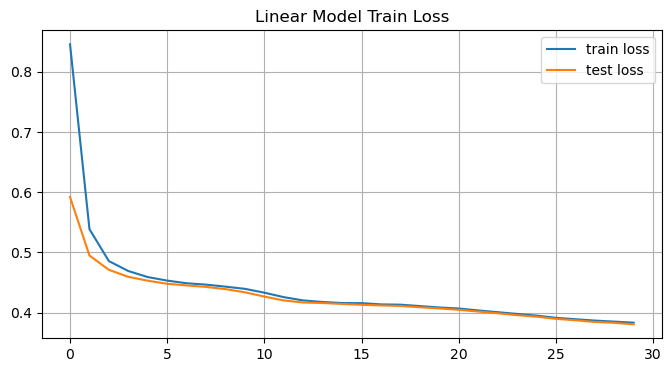

In [32]:
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

plt.figure(figsize=(8, 4))
plt.plot(train_loss_records, label="train loss")
plt.plot(test_loss_records, label="test loss")
plt.title("Linear Model Train Loss")
plt.legend()

plt.grid()
plt.show()